# Imports necesarios

In [ ]:
!pip install geopandas geoplot

In [2]:
!git clone https://github.com/jschleuss/mexican-states.git

Cloning into 'mexican-states'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (4/4), done.
remote: Total 25 (delta 3), reused 3 (delta 3), pack-reused 21
Unpacking objects: 100% (25/25), done.


In [3]:
import re
import geopandas
import geoplot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

#Cargamos el DataSet

In [4]:
# ruta_csv = "/content/SSNMX_catalogo_19800301_20220307.csv"
ruta_csv = "/content/drive/MyDrive/Colab Notebooks/curso pandas/SSNMX_catalogo_19800301_20220307.csv"

In [5]:
df_terre = pd.read_csv(ruta_csv, skiprows=4, skip_blank_lines=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
df_terre.head(4)

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,1980-03-01,04:39:55,no calculable,16.64,-94.71,129.0,"22 km al NORESTE de UNION HIDALGO, OAX",1980-03-01,10:39:55,revisado
1,1980-03-01,12:56:11,no calculable,17.18,-102.34,33.0,"87 km al SUR de CD LAZARO CARDENAS, MICH",1980-03-01,18:56:11,revisado
2,1980-03-01,16:10:53,no calculable,15.41,-93.92,33.0,"77 km al SUR de TONALA, CHIS",1980-03-01,22:10:53,revisado
3,1980-03-02,03:23:30,4.8,14.84,-96.86,33.0,"109 km al SUROESTE de S PEDRO POCHUTLA, OAX",1980-03-02,09:23:30,revisado


# Manejo de Fechas

In [7]:
# df_sample = df_terre['Fecha UTC'] + ' ' +df_terre['Hora UTC']


# df_sample = df_sample.apply( lambda x: pd.to_datetime(x, errors='coerce') )


# df_terre['Fecha y Hora UTC'] = df_sample


df_terre['Fecha y Hora UTC'] = (df_terre['Fecha UTC'] + ' ' +df_terre['Hora UTC']).apply(
    lambda x: pd.to_datetime(x, errors='coerce')
)


In [8]:
df_terre.drop(
    columns = ['Fecha', 'Hora', 'Fecha UTC', 'Hora UTC'],
    inplace= True
)
df_terre.dropna(inplace=True)

In [9]:
df_terre['Año'] = df_terre['Fecha y Hora UTC'].apply(lambda x: x.year)

In [10]:
df_terre.head(5)

,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Estatus,Fecha y Hora UTC,Año
0,no calculable,16.64,-94.71,129.0,"22 km al NORESTE de UNION HIDALGO, OAX",revisado,1980-03-01 10:39:55,1980
1,no calculable,17.18,-102.34,33.0,"87 km al SUR de CD LAZARO CARDENAS, MICH",revisado,1980-03-01 18:56:11,1980
2,no calculable,15.41,-93.92,33.0,"77 km al SUR de TONALA, CHIS",revisado,1980-03-01 22:10:53,1980
3,4.8,14.84,-96.86,33.0,"109 km al SUROESTE de S PEDRO POCHUTLA, OAX",revisado,1980-03-02 09:23:30,1980
4,no calculable,15.30,-97.25,33.0,"65 km al SUROESTE de PUERTO ESCONDIDO, OAX",revisado,1980-03-02 09:29:14,1980


# Definicion de Funciones

In [11]:
nom_est_completos = {
    "OAX": 'Oaxaca',
    "CHIS": 'Chiapas',
    "MICH": 'Michoacán',
    "GRO": 'Guerrero',
    "BC": 'Baja California',
    'JAL': 'Jalisco',
    'COL': 'Colima',
    'VER': 'Veracruz',
    'BCS': 'Baja California Sur',
    'SON': 'Sonora',
    'PUE': 'Puebla',
    'SIN': 'Sinaloa',
    'MEX': 'Estado de México',
    'HGO': 'Hidalgo',
    'TAB': 'Tabasco',
    'NL': 'Nuevo León',
    'CHIH': 'Chihuahua',
    'CDMX': 'Ciudad de México',
    'ZAC': 'Zacatecas',
    'NAY': 'Nayarit',
    'MOR': 'Morelos',
    'SLP': 'San Luis Potosí',
    'COAH': 'Coahuila',
    'TAMS': 'Tamaulipas',
    'TLAX': 'Tlaxcala',
    'GTO': 'Guanajuato',
    'QR': 'Quintana Roo',
    'DGO': 'Durango',
    'CAMP': 'Campeche',
    'AGS': 'Aguascalientes',
    'QRO': 'Querétaro',
    'YUC': 'Yucatán'
}

In [12]:
def acronimos(estado):
  patron = '(.+,\ )([A-Z]{2,4})'
  acro = re.search(pattern=patron, string=estado)
  if acro is not None:
    return acro.group(2)
  else:
    return None


def municipio(referencia):
  patron= r"(\w+\skm\sal\s\w+\sde\s)(.+)(,\s.+)"

  municipio = re.search(pattern=patron, string=referencia)
  
  if municipio is not None:
    return municipio.group(2)
  else:
    return None



##  FUNCIONES DE VISUALIZACION CON SEABORN
def displot_sbn_df(
    df: pd.DataFrame, 
    x: str, 
    hue: Optional[str] = None, 
    y_name: Optional[str] = None
):
  plt.figure(figsize=(14,10))

  dis = sns.displot(
      df,
      x = x,
      hue= hue,
      kde = True,
      height=10, 
      aspect=.9,
  )
  dis.set_axis_labels(x_var=x, y_var=y_name)


def countplot_sbn_df(df: pd.DataFrame, y: str):
  plt.figure(figsize=(14,10))

  sns.countplot(
      data= df,
      y= y,
      order= df[y].value_counts().index
  )


def boxplot_swarmplot_sbn_df(df: pd.DataFrame, x: str, y: str):
  plt.figure(figsize=(16,12))

  sns.boxplot(
      data= df,
      x= x,
      y= y,
  )

  sns.swarmplot(
      data= df,
      x= x,
      y= y,
      color= '.25'
  )



### FUNCION PARA CREAR UN DF PARA UN ESTADO EN ESPECIFICO
def crear_df_estado(estado: str):
  return df_bak[df_bak['Estado'].isin([estado])]

# Agregamos el Año, Estado y Municipio

In [13]:
df_terre.dtypes

Magnitud                              object
Latitud                              float64
Longitud                             float64
Profundidad                           object
Referencia de localizacion            object
Estatus                               object
Fecha y Hora UTC              datetime64[ns]
Año                                    int64
dtype: object

In [14]:
df_terre['Estado'] = df_terre['Referencia de localizacion'].apply(
    lambda x: acronimos(str(x)),
)


df_terre.replace(
    {'Estado': nom_est_completos},
    inplace= True
)


df_terre['Municipio'] = df_terre['Referencia de localizacion'].apply(
    lambda x: municipio(str(x))
)

In [15]:
df_terre['Estado'].value_counts().head()

Oaxaca             98856
Chiapas            44377
Guerrero           42165
Michoacán          14506
Baja California     9660
Name: Estado, dtype: int64

In [16]:
df_terre['Municipio'].value_counts().head()

PINOTEPA NACIONAL    32737
SALINA CRUZ          19216
CD HIDALGO           11273
OMETEPEC              9458
RIO GRANDE            8712
Name: Municipio, dtype: int64

# Copia del DataFrame

In [17]:
df_bak = df_terre.reindex(
    columns = [
      'Referencia de localizacion','Municipio', 'Estado',
      'Fecha y Hora UTC',
      'Año', 'Estatus','Magnitud','Latitud','Profundidad'      
    ]
).copy(deep= True)

In [18]:
df_bak.to_csv('clean_terremotos.csv')

In [19]:
df_bak

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad
0,"22 km al NORESTE de UNION HIDALGO, OAX",UNION HIDALGO,Oaxaca,1980-03-01 10:39:55,1980,revisado,no calculable,16.64,129.0
1,"87 km al SUR de CD LAZARO CARDENAS, MICH",CD LAZARO CARDENAS,Michoacán,1980-03-01 18:56:11,1980,revisado,no calculable,17.18,33.0
2,"77 km al SUR de TONALA, CHIS",TONALA,Chiapas,1980-03-01 22:10:53,1980,revisado,no calculable,15.41,33.0
3,"109 km al SUROESTE de S PEDRO POCHUTLA, OAX",S PEDRO POCHUTLA,Oaxaca,1980-03-02 09:23:30,1980,revisado,4.8,14.84,33.0
4,"65 km al SUROESTE de PUERTO ESCONDIDO, OAX",PUERTO ESCONDIDO,Oaxaca,1980-03-02 09:29:14,1980,revisado,no calculable,15.30,33.0
...,...,...,...,...,...,...,...,...,...
240752,"55 km al SUR de COALCOMAN, MICH",COALCOMAN,Michoacán,2022-03-07 21:26:49,2022,verificado,3.8,18.28,59.0
240753,"30 km al NORESTE de PUERTO ESCONDIDO, OAX",PUERTO ESCONDIDO,Oaxaca,2022-03-07 21:33:06,2022,verificado,3.7,15.97,45.0
240754,"74 km al SUR de SALINA CRUZ, OAX",SALINA CRUZ,Oaxaca,2022-03-07 21:39:33,2022,verificado,3.8,15.53,25.0
240755,"62 km al SUROESTE de PETATLAN, GRO",PETATLAN,Guerrero,2022-03-07 22:09:05,2022,verificado,3.7,17.06,16.0


# Seaborn

### Distribucion de Terremotos por Años

<Figure size 1008x720 with 0 Axes>

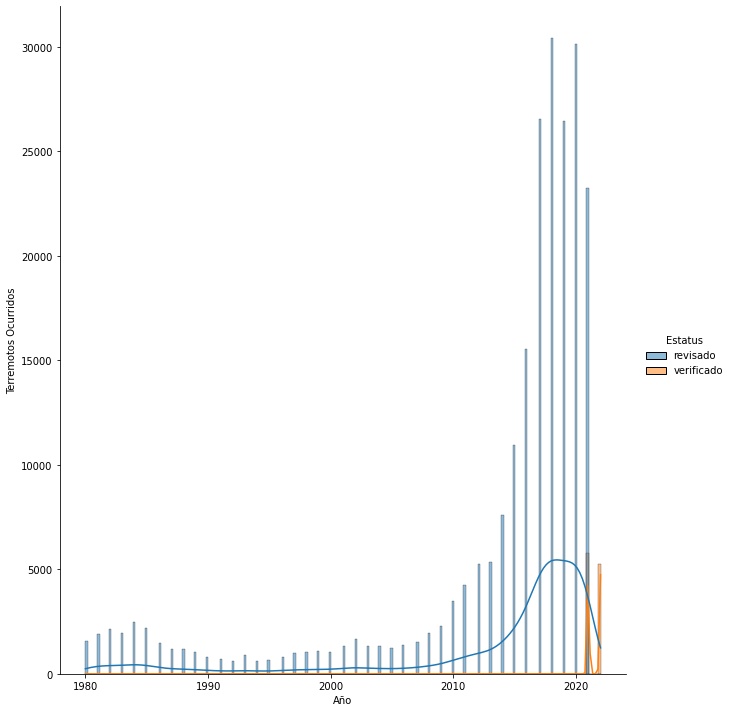

In [20]:
displot_sbn_df(df= df_terre, x='Año', hue='Estatus', y_name='Terremotos Ocurridos')

### Conteo de terremotos por Estados

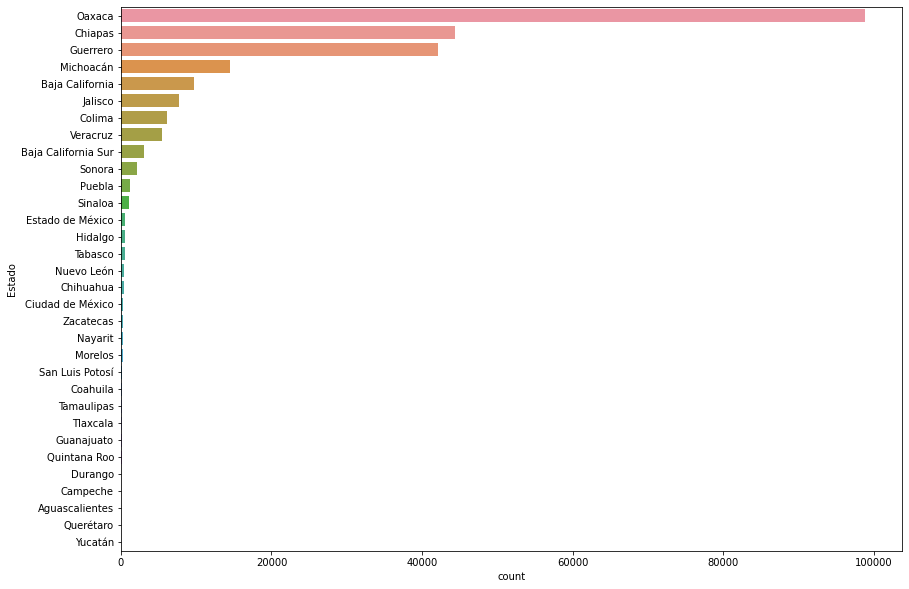

In [21]:
countplot_sbn_df(df_terre, y= 'Estado')

# Dataset Estado

In [22]:
df_bak['Estado'].value_counts()

Oaxaca                 98856
Chiapas                44377
Guerrero               42165
Michoacán              14506
Baja California         9660
Jalisco                 7744
Colima                  6071
Veracruz                5442
Baja California Sur     3023
Sonora                  2095
Puebla                  1191
Sinaloa                 1034
Estado de México         599
Hidalgo                  572
Tabasco                  543
Nuevo León               447
Chihuahua                400
Ciudad de México         292
Zacatecas                279
Nayarit                  264
Morelos                  251
San Luis Potosí          198
Coahuila                 126
Tamaulipas               124
Tlaxcala                 120
Guanajuato               103
Quintana Roo              84
Durango                   63
Campeche                  62
Aguascalientes            45
Querétaro                 15
Yucatán                    3
Name: Estado, dtype: int64

In [23]:
df_Estado = crear_df_estado(estado='Nuevo León')

df_Estado.head()

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad
12661,"54 km al SUROESTE de CD DE ALLENDE, NL",CD DE ALLENDE,Nuevo León,1986-02-26 22:49:56,1986,revisado,4.5,24.83,9.0
13128,"60 km al SUROESTE de LINARES, NL",LINARES,Nuevo León,1986-06-08 08:52:55,1986,revisado,3.7,24.50,9.0
18603,"6 km al SURESTE de HIDALGO, NL",HIDALGO,Nuevo León,1991-11-16 03:39:01,1991,revisado,no calculable,25.92,5.0
19044,"33 km al SUROESTE de LINARES, NL",LINARES,Nuevo León,1992-07-30 14:40:55,1992,revisado,4.3,24.70,10.0
26260,"45 km al SUROESTE de LINARES, NL",LINARES,Nuevo León,2000-09-20 06:24:59,2000,revisado,4.2,24.62,33.0


In [24]:
df_Estado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 12661 to 237205
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Referencia de localizacion  447 non-null    object        
 1   Municipio                   447 non-null    object        
 2   Estado                      447 non-null    object        
 3   Fecha y Hora UTC            447 non-null    datetime64[ns]
 4   Año                         447 non-null    int64         
 5   Estatus                     447 non-null    object        
 6   Magnitud                    447 non-null    object        
 7   Latitud                     447 non-null    float64       
 8   Profundidad                 447 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 34.9+ KB


In [25]:
df_Estado.shape

(447, 9)

# Seaborn Estado

### Distribucion por Años de Terremotos en el Estado Seleccionado

<Figure size 1008x720 with 0 Axes>

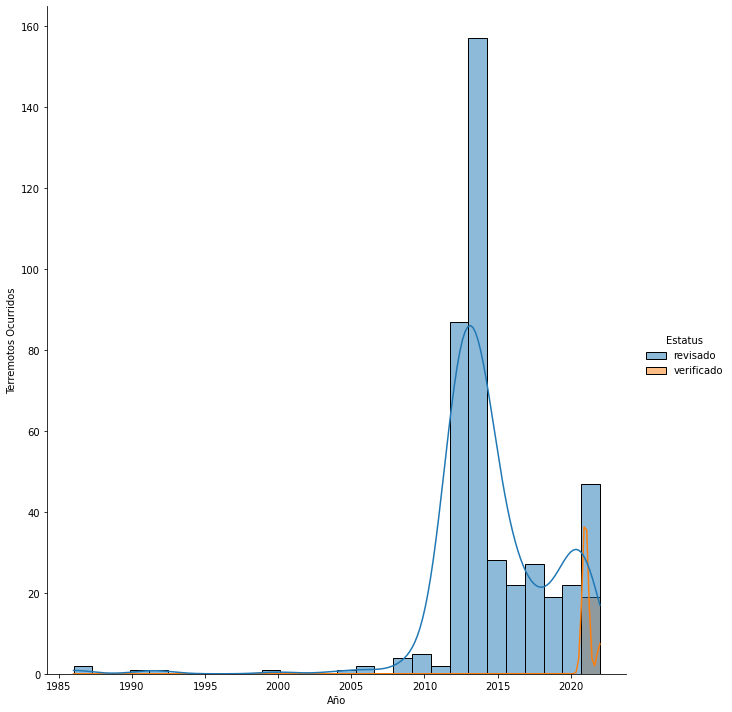

In [26]:
displot_sbn_df(df=df_Estado, x='Año', hue='Estatus', y_name='Terremotos Ocurridos')

### Conteo de Terremotos por Años en el Estado

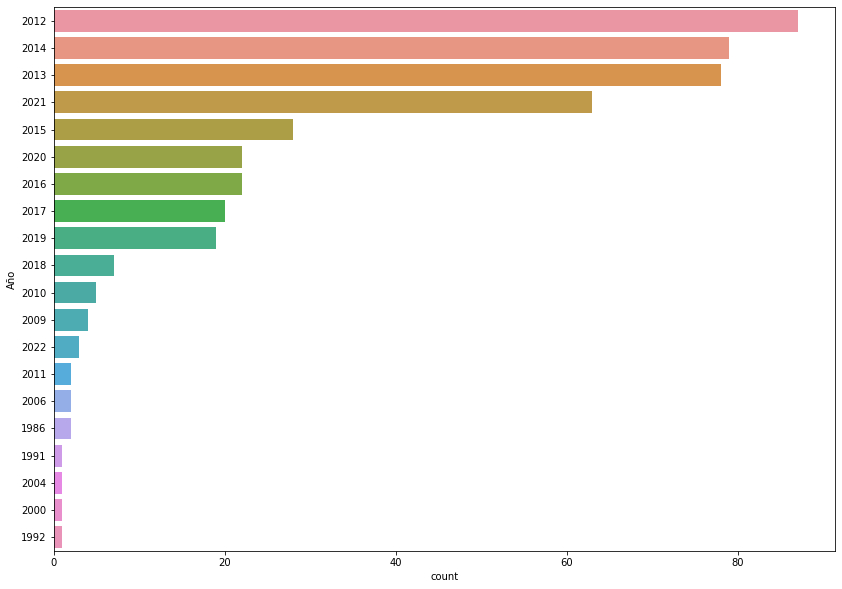

In [27]:
countplot_sbn_df(df=df_Estado, y='Año')

# Municipios del Estado

In [28]:
df_Estado['Municipio'].head()

12661    CD DE ALLENDE
13128          LINARES
18603          HIDALGO
19044          LINARES
26260          LINARES
Name: Municipio, dtype: object

In [29]:
df_Estado.sample(5)

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad
59919,"43 km al NORESTE de MONTEMORELOS, NL",MONTEMORELOS,Nuevo León,2014-03-03 05:00:43,2014,revisado,3.4,25.4298,5.0
61515,"23 km al NORESTE de CIENEGA DE FLORES, NL",CIENEGA DE FLORES,Nuevo León,2014-06-03 18:54:08,2014,revisado,3.6,26.0655,5.0
31215,"29 km al ESTE de MONTEMORELOS, NL",MONTEMORELOS,Nuevo León,2004-04-06 19:01:01,2004,revisado,4.5,25.2200,11.0
57798,"43 km al NORESTE de MONTEMORELOS, NL",MONTEMORELOS,Nuevo León,2013-10-28 22:30:36,2013,revisado,3.5,25.5065,2.0
223836,"9 km al NOROESTE de CD STA CATARINA, NL",CD STA CATARINA,Nuevo León,2021-08-26 13:10:52,2021,revisado,3.4,25.7357,25.0


### Conteo de Terremotos por Municipios en el Estado

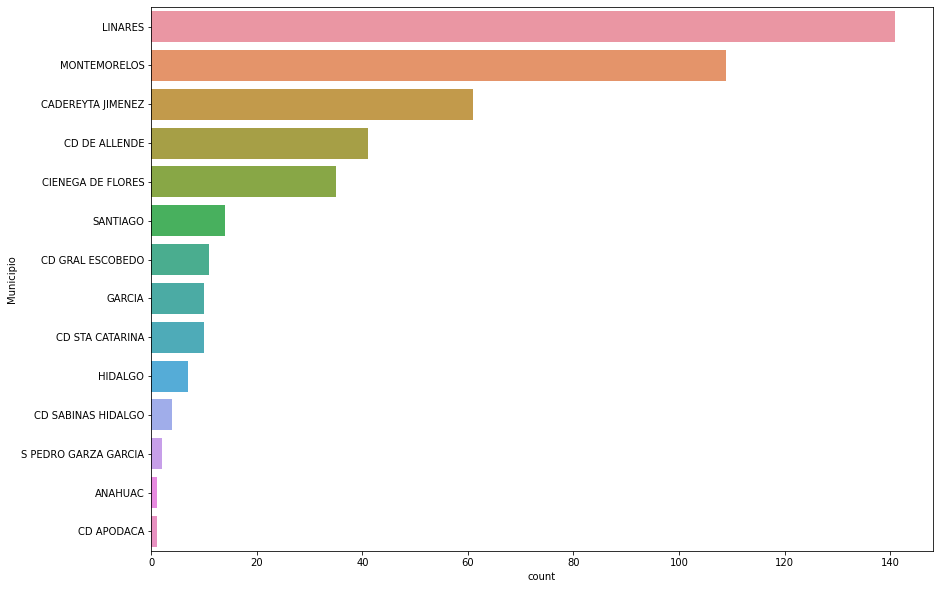

In [30]:
countplot_sbn_df(df= df_Estado, y= 'Municipio')

#Seaborn Magnitud de Terremoto

In [31]:
df_Estado['Magnitud_F'] = pd.to_numeric(
    df_Estado['Magnitud'],
    errors='coerce'
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
df_Estado.sample(5)

,Referencia de localizacion,Municipio,Estado,Fecha y Hora UTC,Año,Estatus,Magnitud,Latitud,Profundidad,Magnitud_F
59941,"79 km al ESTE de CADEREYTA JIMENEZ, NL",CADEREYTA JIMENEZ,Nuevo León,2014-03-04 10:40:06,2014,revisado,3.4,25.6492,16.0,3.4
58151,"37 km al NORESTE de MONTEMORELOS, NL",MONTEMORELOS,Nuevo León,2013-11-20 16:14:02,2013,revisado,3.7,25.3438,71.8,3.7
206302,"11 km al OESTE de CIENEGA DE FLORES, NL",CIENEGA DE FLORES,Nuevo León,2020-12-29 00:06:57,2020,revisado,2.8,25.9330,10.0,2.8
217669,"38 km al NORESTE de CIENEGA DE FLORES, NL",CIENEGA DE FLORES,Nuevo León,2021-06-03 19:19:30,2021,revisado,3.1,26.1400,5.0,3.1
223836,"9 km al NOROESTE de CD STA CATARINA, NL",CD STA CATARINA,Nuevo León,2021-08-26 13:10:52,2021,revisado,3.4,25.7357,25.0,3.4


In [ ]:
boxplot_swarmplot_sbn_df(df=df_Estado, x='Magnitud_F', y='Municipio')

# Geopandas

###Correccion de Nombres de Estados de Pandas

In [34]:
mex=geopandas.read_file("./mexican-states/mexican-states.shp")

In [35]:
mex.name.unique()

array(['Aguascalientes', 'Colima', 'Tlaxcala', 'Ciudad de México',
       'Morelos', 'México', 'Hidalgo', 'Puebla', 'Nuevo León',
       'Coahuila de Zaragoza', 'Chihuahua', 'Sonora',
       'Michoacán de Ocampo', 'Querétaro', 'Guanajuato', 'Jalisco',
       'Zacatecas', 'Durango', 'Tamaulipas',
       'Veracruz de Ignacio de la Llave', 'Guerrero', 'Sinaloa', 'Oaxaca',
       'Nayarit', 'Chiapas', 'Tabasco', 'Campeche', 'Baja California',
       'Baja California Sur', 'San Luis Potosí', 'Yucatán',
       'Quintana Roo'], dtype=object)

In [36]:
mex.loc[mex.name=='Michoacán de Ocampo','name'] ='Michoacán'
mex.loc[mex.name=='Coahuila de Zaragoza','name'] ='Coahuila'
mex.loc[mex.name=='Veracruz de Ignacio de la Llave','name'] ='Veracruz'
mex.loc[mex.name=='México','name'] ='Estado de México'

In [37]:
mex.name.unique()

array(['Aguascalientes', 'Colima', 'Tlaxcala', 'Ciudad de México',
       'Morelos', 'Estado de México', 'Hidalgo', 'Puebla', 'Nuevo León',
       'Coahuila', 'Chihuahua', 'Sonora', 'Michoacán', 'Querétaro',
       'Guanajuato', 'Jalisco', 'Zacatecas', 'Durango', 'Tamaulipas',
       'Veracruz', 'Guerrero', 'Sinaloa', 'Oaxaca', 'Nayarit', 'Chiapas',
       'Tabasco', 'Campeche', 'Baja California', 'Baja California Sur',
       'San Luis Potosí', 'Yucatán', 'Quintana Roo'], dtype=object)

### Group By

In [38]:
df_terre_est = df_bak.copy(deep=True)

In [39]:
df_terre

,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Estatus,Fecha y Hora UTC,Año,Estado,Municipio
0,no calculable,16.64,-94.71,129.0,"22 km al NORESTE de UNION HIDALGO, OAX",revisado,1980-03-01 10:39:55,1980,Oaxaca,UNION HIDALGO
1,no calculable,17.18,-102.34,33.0,"87 km al SUR de CD LAZARO CARDENAS, MICH",revisado,1980-03-01 18:56:11,1980,Michoacán,CD LAZARO CARDENAS
2,no calculable,15.41,-93.92,33.0,"77 km al SUR de TONALA, CHIS",revisado,1980-03-01 22:10:53,1980,Chiapas,TONALA
3,4.8,14.84,-96.86,33.0,"109 km al SUROESTE de S PEDRO POCHUTLA, OAX",revisado,1980-03-02 09:23:30,1980,Oaxaca,S PEDRO POCHUTLA
4,no calculable,15.30,-97.25,33.0,"65 km al SUROESTE de PUERTO ESCONDIDO, OAX",revisado,1980-03-02 09:29:14,1980,Oaxaca,PUERTO ESCONDIDO
...,...,...,...,...,...,...,...,...,...,...
240752,3.8,18.28,-103.17,59.0,"55 km al SUR de COALCOMAN, MICH",verificado,2022-03-07 21:26:49,2022,Michoacán,COALCOMAN
240753,3.7,15.97,-96.81,45.0,"30 km al NORESTE de PUERTO ESCONDIDO, OAX",verificado,2022-03-07 21:33:06,2022,Oaxaca,PUERTO ESCONDIDO
240754,3.8,15.53,-95.05,25.0,"74 km al SUR de SALINA CRUZ, OAX",verificado,2022-03-07 21:39:33,2022,Oaxaca,SALINA CRUZ
240755,3.7,17.06,-101.58,16.0,"62 km al SUROESTE de PETATLAN, GRO",verificado,2022-03-07 22:09:05,2022,Guerrero,PETATLAN
